![alt text](awesome_logo.png "Awesome Retirement Portfolio Projector Tool")

# My Portfolio

In [1]:
import sqlalchemy as sql
import pandas as pd
import os
import datetime
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv

load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [2]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [3]:
# Get porfolio and report data from user
connection_string = 'sqlite:///awesome_app.db'
engine = sql.create_engine(connection_string, echo=False)

portfolio_df = pd.read_sql_query("SELECT * FROM portfolio", engine)

report_df = pd.read_sql_query("SELECT * FROM report", engine)
[risk_tolerance, years_until_retirement] = report_df.iloc[0]

portfolio_df

,symbol,quantity,type
0,GOOG,10.0,Equity
1,CMG,20.0,Equity
2,IBM,50.0,Equity
3,XLB,100.0,Equity


In [4]:
print(f"My risk level is {risk_tolerance}.")
print(f"I plan on retiring in {years_until_retirement} years.")

My risk level is high.
I plan on retiring in 20.0 years.


In [5]:
# Set the tickers
tickers = portfolio_df["symbol"]
# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"
# Set the number of years of data to fetch
num_years = 30

# Fetch batches of data from alpaca api to get as miuch hostorical data as possible (up to num_years)
batch_size = 1000
num_days_data_needed = num_years * 365
first_date = datetime.datetime.now()
last_date = first_date - datetime.timedelta(days=num_days_data_needed)

def format_date_iso(date):
    return pd.Timestamp(date, tz="America/New_York").isoformat()

# empty DF to hold alpaca data
all_results_df = pd.DataFrame()


next_batch_date = first_date
while num_days_data_needed > 0:
    end_date = str(next_batch_date).split()[0]
    
    next_batch_date -= datetime.timedelta(days=batch_size)
    if next_batch_date < last_date:
        next_batch_date = last_date

    start_date = str(next_batch_date).split()[0]
    
    results_batch_df = alpaca.get_barset(
        tickers,
        timeframe,
        start = format_date_iso(start_date),
        end = format_date_iso(end_date),
        limit = batch_size
    ).df
    
    results_batch_df.drop(['open', 'high', 'low', 'volume'], level=1, axis=1, inplace=True)

    all_results_df = pd.concat([all_results_df, results_batch_df])
    num_days_data_needed -= batch_size

all_results_df.sort_index(inplace=True)

# Display data
all_results_df

,CMG,GOOG,IBM,XLB
,close,close,close,close
time,,,,
2008-01-02 00:00:00-05:00,146.68,342.59,104.79,41.33
2008-01-03 00:00:00-05:00,141.46,342.49,104.94,41.80
2008-01-04 00:00:00-05:00,127.12,328.48,101.11,40.74
2008-01-07 00:00:00-05:00,123.61,324.34,100.14,40.25
2008-01-08 00:00:00-05:00,117.77,315.66,97.39,39.60
...,...,...,...,...
2021-08-09 00:00:00-04:00,1875.23,2758.87,141.24,84.06
2021-08-10 00:00:00-04:00,1866.79,2763.32,141.41,85.31


In [11]:
last_price = []
for t in portfolio_df['symbol']:
    last_price.append(all_results_df[t]['close'][-1])

portfolio_df['price'] = last_price
portfolio_df['total'] = portfolio_df['price'] * portfolio_df['quantity']
total_portfolio_value = portfolio_df['total'].sum()

display(portfolio_df)
print(f"Total portfolio valus is ${total_portfolio_value:.2f}")

,symbol,quantity,type,price,total
0,GOOG,10.0,Equity,2769.18,27691.8
1,CMG,20.0,Equity,1888.44,37768.8
2,IBM,50.0,Equity,143.20,7160.0
3,XLB,100.0,Equity,86.45,8645.0


Total portfolio valus is $81265.60


<AxesSubplot:xlabel='time'>

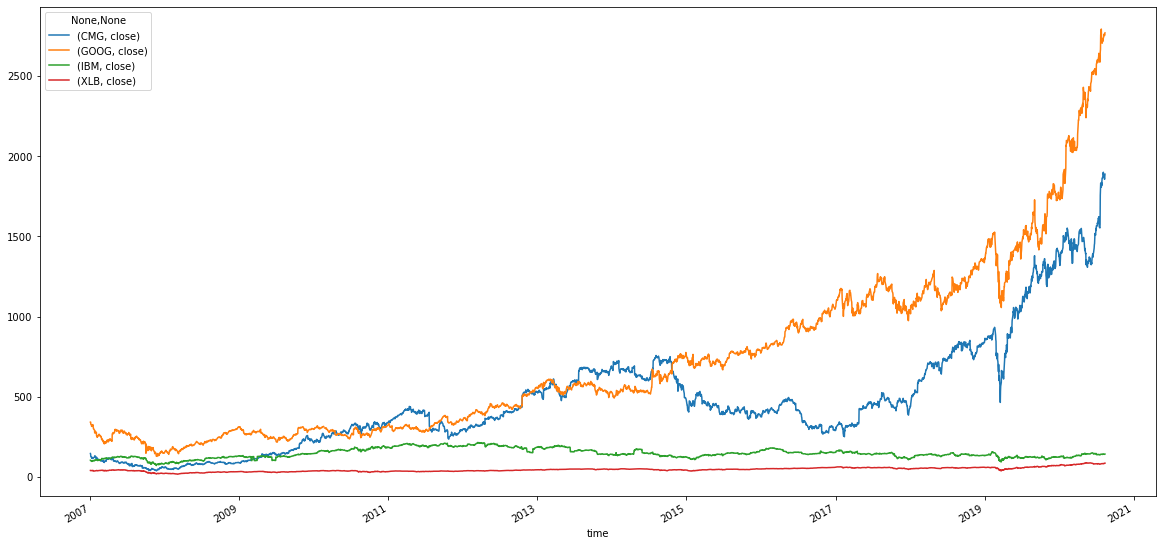

In [7]:
all_close_df = all_results_df.xs('close', axis=1, level=1, drop_level=False)
all_close_df.plot(figsize=[20, 10])

In [8]:
print("Current portfolio expected return")
print("Current portfolio volatility")
print("Current portfolio sharpe ratio")

Current portfolio expected return
Current portfolio volatility
Current portfolio sharpe ratio


---

# My Optimized Portfolio

In [9]:
print("Optimized portfolio expected return")
print("Optimized portfolio volatility")
print("Optimized portfolio sharpe ratio")

Optimized portfolio expected return
Optimized portfolio volatility
Optimized portfolio sharpe ratio
